### packages

In [1]:
# files/general
import csv
import os
import time
import astropy.io.fits as fits
from IPython.display import clear_output
import threading
import warnings
warnings.filterwarnings("ignore")

# math
import numpy as np
import cupy as cp
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as mTSNE
import umap
from skimage.measure import shannon_entropy, block_reduce
from skimage.transform import resize
from sklearn.ensemble import IsolationForest
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from astropy import constants as const

# visuals
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import griddata
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import open3d as o3d
print(o3d.core.cuda.is_available())
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)

# astro
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astroquery.mast import Observations

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
False


### convenience functions

In [4]:
# Ra/DEC to cartesian
def rd_to_xyz(ra, dec, stellar_velocity, d_L):
    ra_rad, dec_rad = np.radians(ra), np.radians(dec)
    X = d_L * np.cos(dec_rad) * np.cos(ra_rad)
    Y = d_L * np.cos(dec_rad) * np.sin(ra_rad)
    Z = d_L + (stellar_velocity / 300.0) * d_L  # Roughly estimating depth using velocity (300 km/s ~ 1 Mpc shift)
    return X, Y, Z

# downsampling
def pooling(image_data, target_size=(9, 9), method='wrap'):
    return resize(image_data, target_size, preserve_range=True, mode=method)

# natural jitter/breathing effect
def jitter_positions(points, intensity=0.1):
    noise = np.random.normal(scale=intensity, size=points.shape)
    return points + noise


life_cycle_stages = {
    'early formation': [0, 1, 2, 3, 4, 5, 8],
    'star formation': [7, 9, 10, 14, 19, 23, 24, 27, 28, 31, 33],
    'stellar evolution': [11, 12, 13, 22, 25, 26],
    'agn activity': [15, 16, 17, 20, 21],
    'late stage evolution': [18, 19, 25, 26, 30, 32, 34],
    'passive evolution': [11, 12, 13, 18, 19, 20, 21, 25, 26]
}

def get_data(file_path, colormap=cm.managua_r, depth_scale_factor = 30, spread_factor = 0.5, depth_layers = 100, downsample=None, pixels_only=False):
    if downsample is not None:
        downsize = downsample - 1
    kms = u.km / u.s
    mask_flags = 1| 4 | 256 | 512
    with fits.open(file_path) as hdul:
    
    # loading data ==========================================================================        
        primary_header = hdul['PRIMARY'].header
        scinpvel = primary_header.get("SCINPVEL", None) * kms # inital object velocity
        objra = primary_header.get("OBJRA", None) * u.deg # right ascension
        objdec = primary_header.get("OBJDEC", None) * u.deg # declination
        
        # flux brightness for "color" --------------------------------------------
        g_flux_data = hdul['SPX_MFLUX'].data
        flux_data = hdul['EMLINE_GFLUX'].data # shape: (35, 74, 74)
        shape = flux_data.shape
        flux_mask = hdul['EMLINE_GFLUX_MASK'].data
        flux_masked = np.where(flux_data == 0 | ~np.isfinite(flux_data), 0, flux_data)
        flux_masked = np.where(np.bitwise_and(flux_mask, mask_flags) == 0, 0, flux_masked) # 1 means pixel unaffected
        flux_data = (flux_masked).reshape(35, -1).T # reshape to (35, 74*74) and transpose to (5476, 35)
        
        # doppler shift for "depth" ----------------------------------------------
        dshift_data = hdul['EMLINE_GVEL'].data[0] + scinpvel.value
        dshift_mask = hdul['EMLINE_GVEL_MASK'].data[0]
        dshift_data_masked = np.where(np.bitwise_and(dshift_mask, mask_flags) == 0 | ~np.isfinite(dshift_data), 0, dshift_data)
        dshift_max = np.nanmax(np.abs(dshift_data_masked.flatten()))
        depth = (dshift_data / dshift_max) * depth_scale_factor
        
        # spread of velocities from mean for "thickness" --------------------------
        spread_map = hdul['EMLINE_GSIGMA'].data[23] * kms
        spread_norm = (spread_map - np.nanmin(spread_map)) / (np.nanmax(spread_map) - np.nanmin(spread_map))
        spread = spread_norm * spread_factor
        
        # pixel coordinates -------------------------------------------------------
        skycoo_x, skycoo_y = hdul['SPX_SKYCOO'].data[0] * u.arcsec, hdul['SPX_SKYCOO'].data[1] * u.arcsec
        delta_ra, delta_dec = (skycoo_x / np.cos(objdec)).to(u.deg), skycoo_y.to(u.deg)
        spaxel_ra, spaxel_dec = (objra + delta_ra), (objdec + delta_dec)
    
    # object info ===========================================================================
    redshift = scinpvel / const.c.to('km/s') # redshift z = stellar velocity / speed of light
    distance = cosmo.luminosity_distance(redshift).to(u.Mpc) # luminosity distance
    
    galaxy_coords = SkyCoord(ra=objra, dec=objdec, distance=np.abs(distance), frame='icrs')
    galaxy_x = galaxy_coords.cartesian.x.to(u.Mpc).value
    galaxy_y = galaxy_coords.cartesian.y.to(u.Mpc).value
    galaxy_z = galaxy_coords.cartesian.z.to(u.Mpc).value
    
    if pixels_only == False:
        plateifu = primary_header.get("PLATEIFU", None)
        age = cosmo.lookback_time(redshift).to('Gyr') # lookback time of universe
        object_info = [plateifu, age.value, distance.value, redshift, scinpvel.value, [galaxy_x, galaxy_y, galaxy_z]]
    
    # pixel info ============================================================================
    spaxel_coords = SkyCoord(ra=spaxel_ra, dec=spaxel_dec, frame='icrs')
    spaxel_cartesian = spaxel_coords.cartesian.with_differentials(
        SkyCoord(ra=spaxel_ra, dec=spaxel_dec, distance=np.abs(distance)).cartesian.differentials
    ) # scale to physical space
    
    x, y = np.indices(dshift_data.shape)
    x = galaxy_x + x + spaxel_cartesian.x.value
    y = galaxy_y + y + spaxel_cartesian.y.value
    z = galaxy_z + depth + spaxel_cartesian.z.value
    
    iso_forest = IsolationForest(contamination=0.30, max_samples=35, random_state=42, n_estimators=200)  # contamination: % expected outliers
    channels = [(shannon_entropy(flux_data[:, i]), np.std(flux_data[:, i])) for i in range(35)]
    labels = iso_forest.fit_predict(channels)
    selected_channels = np.where(labels == 1)[0]
    
    colors = [] # UNITLESS because of log1p. final shape before tiling: (6, 5476, 3)
    for j, (stage, channels) in enumerate(life_cycle_stages.items()):
        selection = [c for c in channels if c in selected_channels]
        stage_flux = np.sum(flux_data[:, selection], axis=1) # sum across channels. flux_data shape: (n points, 35)
        stage_flux = (np.log1p(stage_flux)).reshape(shape[1], shape[2]) # apparently not all of the images are 74x74...
        if downsample is not None:
            downsampled_flux = pooling(stage_flux, target_size=(downsize, downsize)) # downsampling because of memory issues
            downsampled_g = pooling(g_flux_data, target_size=(downsize, downsize))
            stage_flux = downsampled_flux.flatten() + downsampled_g.flatten()
        else:
            stage_flux = stage_flux.flatten() + g_flux_data.flatten()
        norm = plt.Normalize(vmin=np.min(stage_flux), vmax=np.max(stage_flux))
        stage_colors = colormap(norm(stage_flux))[..., :3] # mapping flux values to R, G, B (no alpha)
        colors.append(stage_colors) # add stages as "channels"
    all_colors = np.tile(np.array(colors), (depth_layers, 1))
    
    points = []
    for j in range(depth_layers):
        z_offset = spread.value * (j - depth_layers // 2)
        new_z = z + z_offset # adding more layers of depth
        if downsample is not None:
            downsample_x = pooling(x, target_size=(downsize, downsize))
            downsample_y = pooling(y, target_size=(downsize, downsize))
            downsample_z = pooling(new_z, target_size=(downsize, downsize))
            point_samples = np.column_stack([downsample_x.flatten(), downsample_y.flatten(), downsample_z.flatten()])
        else:
            point_samples = np.column_stack([x.flatten(), y.flatten(), new_z.flatten()])
        points.append(point_samples)
    all_points = np.vstack(np.array(points))
    
    pixel_info = [all_points, all_colors]
    # =======================================================================================
    if pixels_only == False:
        return object_info, pixel_info
    if pixels_only == True:
        return pixel_info

### combo dataset

[COMBO-17 Dataset](https://www.kaggle.com/datasets/mrisdal/combo17-galaxy-dataset?resource=download)

[About](https://sites.psu.edu/astrostatistics/datasets-combo-17/)

In [2]:
dataset = pd.read_csv("../../moodo/COMBO17.csv", header=0)
print(dataset.shape)
print(dataset.columns)

(3462, 65)
Index(['Nr', 'Rmag', 'e.Rmag', 'ApDRmag', 'mumax', 'Mcz', 'e.Mcz', 'MCzml',
       'chi2red', 'UjMAG', 'e.UjMAG', 'BjMAG', 'e.BjMAG', 'VjMAG', 'e.VjMAG',
       'usMAG', 'e.usMAG', 'gsMAG', 'e.gsMAG', 'rsMAG', 'e.rsMAG', 'UbMAG',
       'e.UbMAG', 'BbMAG', 'e.BbMAG', 'VnMAG', 'e.VbMAG', 'S280MAG',
       'e.S280MA', 'W420FE', 'e.W420FE', 'W462FE', 'e.W462FE', 'W485FD',
       'e.W485FD', 'W518FE', 'e.W518FE', 'W571FS', 'e.W571FS', 'W604FE',
       'e.W604FE', 'W646FD', 'e.W646FD', 'W696FE', 'e.W696FE', 'W753FE',
       'e.W753FE', 'W815FS', 'e.W815FS', 'W856FD', 'e.W856FD', 'W914FD',
       'e.W914FD', 'W914FE', 'e.W914FE', 'UFS', 'e.UFS', 'BFS', 'e.BFS', 'VFD',
       'e.VFD', 'RFS', 'e.RFS', 'IFD', 'e.IFD'],
      dtype='object')


Mcz - preferred estimate of redshift

Col 10-29: These give the absolute magnitudes (i.e. intrinsic luminosities) of the galaxy in 10 bands, with their measurement errors.  They are based on the measured magnitudes and the redshifts, and represent the intrinsic luminosities of the galaxies; a galaxy with M=-15 is 100-times less luminous than one with M=-20.    These magnitudes are not all independent of each others, but the are important for representing intrinsic properties of the galaxies.  Below is one of several redshift-stratified plots of the <b>B-band absolute magnitude (abscissa) against the difference of magnitude (i.e. ratio of luminosities) between the 2800A ultraviolet and blue band, which is a sensitive indicator of star formation</b>.  A redshift-dependent bimodal distribution is seen. 

'UjMAG', 'e.UjMAG', 'BjMAG', 'e.BjMAG', 'VjMAG', 'e.VjMAG',
       'usMAG', 'e.usMAG', 'gsMAG', 'e.gsMAG', 'rsMAG', 'e.rsMAG', 'UbMAG',
       'e.UbMAG', 'BbMAG', 'e.BbMAG', 'VnMAG', 'e.VbMAG', 'S280MAG',
       'e.S280MA'

In [3]:
band_magnitudes = ['UjMAG', 'BjMAG', 'VjMAG', 'usMAG', 'gsMAG', 'rsMAG', 'UbMAG', 'BbMAG', 'VnMAG','S280MAG']


subset = dataset[['Nr', 'Mcz'] + band_magnitudes]
print(subset.shape)
print(subset.columns)

# remove nan values
subset = subset.dropna()

(3462, 12)
Index(['Nr', 'Mcz', 'UjMAG', 'BjMAG', 'VjMAG', 'usMAG', 'gsMAG', 'rsMAG',
       'UbMAG', 'BbMAG', 'VnMAG', 'S280MAG'],
      dtype='object')


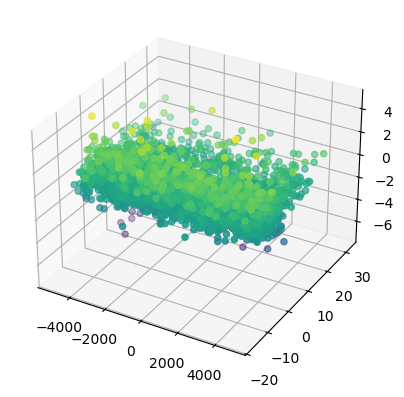

In [4]:
pca = PCA()
data_pca = pca.fit_transform(subset)
pca_3d = data_pca[:, :3]

# 3d scatter plot, color plot point based on value of Mcz
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = pca_3d[:, 2]
colors = colors - np.min(colors)
colors = colors / np.max(colors)
colors = plt.cm.viridis(colors)
ax.scatter(pca_3d[:, 0], pca_3d[:, 1], pca_3d[:, 2], c=colors)

### MaNGA dataset

#### search & download data

In [2]:
manga_obs_list = Observations.query_criteria(provenance_name='MaNGA')

print(len(manga_obs_list))
print(manga_obs_list.colnames)

11273
['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURL', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID']


In [3]:
manga_products = Observations.get_product_list(manga_obs_list)

manga_maps = Observations.filter_products(manga_products,
                                          mrp_only=True,
                                          productSubGroupDescription="MAPS")

len(manga_maps)

10734

In [ ]:
# Observations.download_products(manga_maps, download_dir='../../universe', flat=True)

Local Path,Status,Message,URL
str69,str8,object,object
../../universe\manga-10001-12701-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz,COMPLETE,None,None
../../universe\manga-10001-12702-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz,COMPLETE,None,None
../../universe\manga-10001-12703-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz,COMPLETE,None,None
../../universe\manga-10001-12704-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz,COMPLETE,None,None
../../universe\manga-10001-12705-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz,COMPLETE,None,None
../../universe\manga-10001-1901-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz,COMPLETE,None,None
../../universe\manga-10001-1902-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz,COMPLETE,None,None
../../universe\manga-10001-3701-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz,COMPLETE,None,None
../../universe\manga-10001-3702-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz,COMPLETE,None,None


#### data exploration

HEADERS NEEDED: 
'SCINPVEL' in 'PRIMARY' <-- this is what to use for calculating lookback time
channel 'Ha-6564' in 'EMLINE_GFLUX'
--> 'EMLINE_GFLUX' contains WCS


Gaussian-fit Emission-Line Channels:

Key	 Value	  Type	Comment
C24	 Ha-6564  str	Data in channel 24

In [3]:
data_folder = '../../MaNGA/raw'
maps_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder)]
len(maps_files)

10734

##### calculating steps (estimate)

In [31]:
lookback_list = []
n=1
for file in maps_files:
    with fits.open(file) as manga_map:
            
        primary_header = manga_map['PRIMARY'].header
        plateifu = primary_header.get("PLATEIFU", None)
        scinpvel = primary_header.get("SCINPVEL", None)

        if scinpvel is not None:
            # redshift z = v / c
            z = scinpvel / const.c.to('km/s').value
            lookback_time = cosmo.lookback_time(z).to('Gyr').value
            lookback_list.append(lookback_time)
        
        print(f'{n}/{len(maps_files)}', end='\r')
        n+=1

In [32]:
# find negative lookback times
negative_lookback = {i: lookback for i, lookback in enumerate(lookback_list) if lookback < 0}

for key in negative_lookback.keys():
    with fits.open(maps_files[key]) as manga_map:
            
        primary_header = manga_map['PRIMARY'].header
        plateifu = primary_header.get("PLATEIFU", None)
        scinpvel = primary_header.get("SCINPVEL", None)

        if scinpvel is not None:
            z = scinpvel / const.c.to('km/s').value
            lookback_time = cosmo.lookback_time(z).to('Gyr').value
            
            print(f'[Plateifu] {plateifu}')
            print(f'lookback_list index: {key}')
            print(f'Stellar Velocity: {scinpvel} km/s | Z: {z} | Lookback time: {lookback_time} Gyr \n')

[Plateifu] 8309-1901
lookback_list index: 5424
Stellar Velocity: -194.773061415394 km/s | Z: -0.0006496930000000001 | Lookback time: -0.00939354963615193 Gyr 



In [40]:
fps = 60
lookbacktimes = np.unique(lookback_list)
n_lookbacktimes = len(lookbacktimes)
print(f'[Unique Years]: {n_lookbacktimes} ({len(np.where(lookbacktimes < 0)[0])} negative times)')

# diffs = [b - a for a, b in zip(lookbacktimes, lookbacktimes[1:])]
diffs = np.diff(lookbacktimes) # same as above, but more efficient
print(f'[Diffs] | Mean: {np.mean(diffs):.6f} Gyr | Q1: {np.percentile(diffs, 25):.6f} Gyr | Median: {np.median(diffs):.6f} Gyr | Q3: {np.percentile(diffs, 75):.6f} Gyr | StDev: {np.std(diffs):.6f} Gyr')

percentile = 90
step_size = np.percentile(diffs, percentile)

# z_scores = np.abs((diffs - np.mean(diffs)) / np.std(diffs)) # number of stdevs away from the mean
# threshold = 10000
# step_size = np.mean(diffs[z_scores <= threshold])

steps = np.arange(min(lookbacktimes), max(lookbacktimes), step_size)
frames = len(steps)

vid_length = frames / fps
m, s = divmod(vid_length, 60)
h, m = divmod(m, 60)

print(f'[Range]: {max(lookbacktimes) - min(lookbacktimes):.3f} Gyr')
print(f'[Step size]: {step_size} Gyr ({step_size * 1e9:.2f} years)')
print(f'[Video length]: {h:.0f}h {m:.0f}m {s:.2f}s ({int(frames)} frames)')


[Unique Years]: 10114 (1 negative times)
[Diffs] | Mean: 0.000329 Gyr | Q1: 0.000025 Gyr | Median: 0.000066 Gyr | Q3: 0.000166 Gyr | StDev: 0.011827 Gyr
[Range]: 3.326 Gyr
[Step size]: 0.00042302642913816257 Gyr (423026.43 years)
[Video length]: 0h 2m 11.05s (7863 frames)


[Zero steps]: 4948
Step with the maximum counts: -0.000087 Gyr (Step 22)


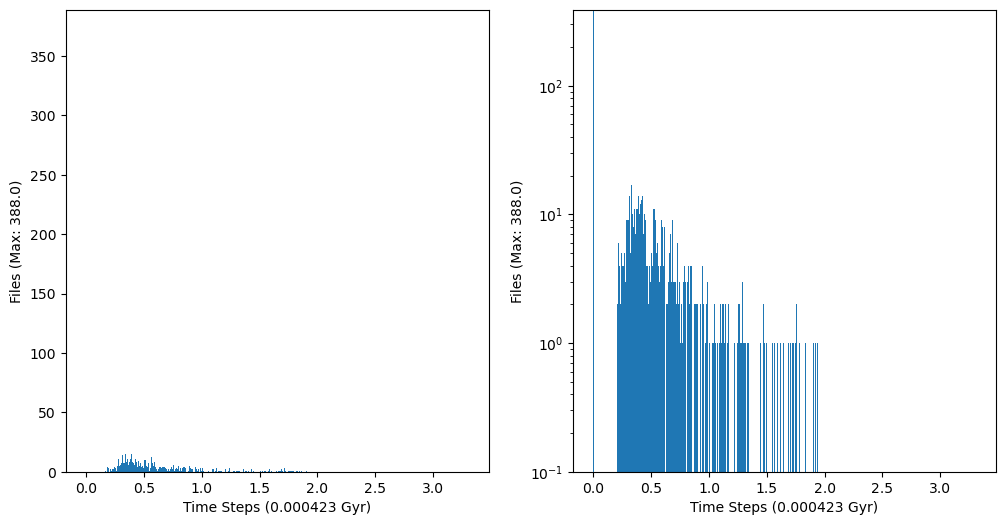

In [7]:
# find where step_counts is 0
step_counts = np.zeros(len(steps))
for i, step in enumerate(steps):
    step_counts[i] = len([1 for t in lookback_list if t >= step and t < step + step_size])
zero_steps = np.where(step_counts == 0)[0] # [0] for True?
print(f'[Zero steps]: {len(zero_steps)}')


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
counts, _, _, = plt.hist(lookback_list, bins=steps);
plt.xlabel(f'Time Steps ({step_size:.6f} Gyr)');
plt.ylabel(f'Files (Max: {max(counts)})'), plt.ylim(0, max(counts)+1);

max_count_index = np.argmax(counts)
max_count_step = steps[max_count_index]
print(f'Step with the maximum counts: {max_count_step:.6f} Gyr (Step {max_count_index})')

plt.subplot(1, 2, 2, sharex=plt.subplot(1, 2, 1))
counts, _, _, = plt.hist(lookback_list, bins=steps, log=True);
plt.xlabel(f'Time Steps ({step_size:.6f} Gyr)');
plt.ylabel(f'Files (Max: {max(counts)})'), plt.ylim(0.1, max(counts)+1);

##### test visualizing

In [8]:
file = maps_files[0]

points = []
with fits.open(file) as manga_map:
            
    primary_header = manga_map['PRIMARY'].header
    plateifu = primary_header.get("PLATEIFU", None)
    scinpvel = primary_header.get("SCINPVEL", None)

    if scinpvel is not None:
        # redshift z = v / c
        z = scinpvel / const.c.to('km/s').value
        lookback_time = cosmo.lookback_time(z).to('Gyr').value
        d_L = cosmo.luminosity_distance(z).to(u.Mpc).value
    else:
        z = None
        lookback_time = None
        d_L = None
    
    print(f"Plate-IFU: {plateifu} | z: {z} | Lookback time: {lookback_time:.4f} Gyr | Luminosity distance: {d_L:.4f} Mpc              ", end='\r')
    
    wcs = WCS(manga_map['EMLINE_GFLUX'].header)
    h_alpha_flux = manga_map['EMLINE_GFLUX'].data[23] # 24th channel
    
    nx, ny = h_alpha_flux.shape
    x_grid, y_grid = np.meshgrid(np.arange(nx), np.arange(ny), indexing="ij")

    # Convert spaxels to RA/Dec using WCS
    ra, dec, _ = wcs.all_pix2world(x_grid, y_grid, np.zeros_like(x_grid), 0)

    # Convert RA/Dec to Cartesian coordinates
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)

    X = d_L * np.cos(dec_rad) * np.cos(ra_rad)  # Mpc
    Y = d_L * np.cos(dec_rad) * np.sin(ra_rad)  # Mpc
    Z = d_L * np.sin(dec_rad)  # Mpc
    
    h_alpha_points = np.vstack([X.ravel(), Y.ravel(), Z.ravel(), h_alpha_flux.ravel()]).T
    h_alpha_points = h_alpha_points[~np.isnan(h_alpha_points).any(axis=1)] # remove rows with NaNs
    h_alpha_points = h_alpha_points[h_alpha_points[:, 3] != 0] # remove rows with 0 flux
        
    with open(f'test_points-{plateifu}.csv', 'w') as f:
        f.write('X,Y,Z,H-alpha\n')
        for point in h_alpha_points:
            f.write(f'{point[0]},{point[1]},{point[2]},{point[3]}\n')

In [9]:
test_csv = pd.read_csv('test_points-10001-12701.csv', header=0)

x = np.linspace(test_csv['X'].min(), test_csv['X'].max(), 100)
y = np.linspace(test_csv['Y'].min(), test_csv['Y'].max(), 100)
X, Y = np.meshgrid(x, y)
Z = griddata((test_csv['X'], test_csv['Y']), test_csv['Z'], (X, Y), method='nearest') # interpolation: nearest, linear, or cubic
H_alpha_flux = griddata((test_csv['X'], test_csv['Y']), test_csv['H-alpha'], (X, Y), method='linear')
H_alpha_flux = np.log(H_alpha_flux)

fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'scatter3d'}, {'type': 'surface'}, {'type': 'surface'}]])

# raw data
scatter = go.Scatter3d(x=test_csv['X'], y=test_csv['Y'], z=test_csv['Z'],
    mode='markers',
    marker=dict(size=5, color=test_csv['H-alpha'], colorscale='Viridis', colorbar=dict(title='H-Alpha Flux'))
)
fig.add_trace(scatter, row=1, col=1)

# interpolated
surface1 = go.Surface(x=X, y=Y, z=Z, surfacecolor=H_alpha_flux, colorscale='Viridis', colorbar=dict(title='H-Alpha Flux'))
fig.add_trace(surface1, row=1, col=2)

# contour plot
surface2 = go.Surface(x=X, y=Y, z=H_alpha_flux, surfacecolor=H_alpha_flux, colorscale='Viridis', colorbar=dict(title='H-Alpha Flux'))
fig.add_trace(surface2, row=1, col=3)

# settings
fig.update_layout(
    scene=dict(
        xaxis_title='X (Mpc)',
        yaxis_title='Y (Mpc)',
        zaxis_title='Z (Mpc)'
    ),
    title='3D Interactive Plot'
)
fig.show()

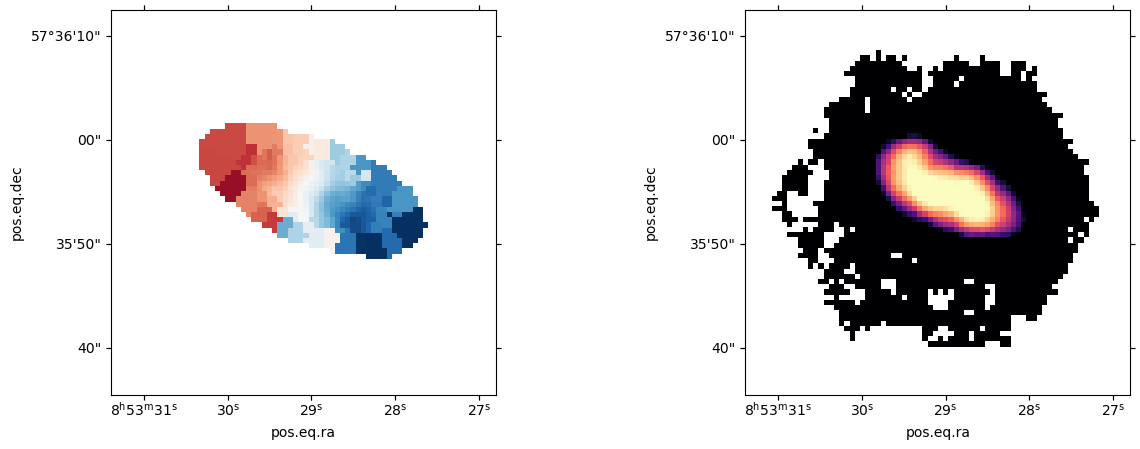

In [10]:
# find file name by plateifu
plateifu = '10001-12701'
file = next(f for f in maps_files if plateifu in f)
manga_map = fits.open(file)
# manga_map.info()

manga_wcs = WCS(manga_map[3].header)

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121, projection=manga_wcs)
ax2 = plt.subplot(122, projection=manga_wcs)

# stellar velocity
qual_mask = manga_map['STELLAR_VEL'].header['QUALDATA'] # mask for quality data
velocity_map = np.ma.MaskedArray(manga_map['STELLAR_VEL'].data,
                                 mask=manga_map[qual_mask].data > 0)
ax1.imshow(velocity_map, interpolation='nearest', 
                vmin=-125, vmax=125, cmap='RdBu_r')

# h-alpha flux
h_alpha_flux = np.copy(manga_map['EMLINE_GFLUX'].data[23])
h_alpha_flux[h_alpha_flux == 0] = np.nan # mask for quality data
ax2.imshow(np.log(h_alpha_flux),
           transform=ax2.get_transform(manga_wcs),
           cmap='magma', vmin=0, vmax=2)

##### object identifier

In [11]:
drpall = fits.open('drpall-v3_1_1.fits')
tbdata = drpall[1].data

plateifu = '10001-12701'
ind = np.where(tbdata['plateifu'] == plateifu)[0]
print(f"MaNGA ID: {tbdata[ind]['mangaid']}")
tbdata

MaNGA ID: ['1-48157']


FITS_rec([(10001, '12701', '10001-12701', '1-48157', 'v3_1_1', 'v3_1_1', 'v1_9_1', 'v5_5_36', 'v2_9', 'APOGEE-2&MaNGA', 'MaNGA dither', 133.37109061, 57.59842514, 159.27921887, 38.83818292, 133.37109, 57.598425, 0.0545561,  9,  8100.81, 0, 20.0835, 41.292 , 'ma079', 22, '3',  9114, 134.41357, 57.604214, 1.10715, 1.15321, 1.21404, 1.78219, 1.85994, 2.12685, 0.898721, 0.929654, 0.937466, 57372, 57373, 57373, 2.69906, 2.64546, 2.59645, 2.54039, 2080, 0, 0, 1, 'plateTargets-1.par', 6013, 'J085329.03+573554.9', 127, 127, 0, 0.0392074, 0.0193562, 0.0264775, 0.0386959, 0.0429176, 0.0193562, 0.0264775, 0.748562, -9.99000e+02, 0.665321 , 0.705378 ,  1.08789e+00,  1.19925e+00, -9.9900e+02, 0.66562  , 0.705713 , 203, 1350, 6, 'v1_0_1',  51226, -999, 0.0392074, 0.0395926, [-16.2982, -16.7751, -17.7885, -18.7652, -19.198 , -19.3399, -19.5112], [-16.2321, -16.7716, -17.9054, -18.7874, -19.2112, -19.3438, -19.5522], [2.75541e+02, 4.82756e+02, 7.71392e+01, 2.22872e+03, 9.84408e+02, 2.00050e+03, 4.5294

##### spatial understanding (iteration 1)

In [12]:
def get_coords(file_path, voxel_size):
    kms = u.km / u.s
    
    with fits.open(file_path) as hdul:
        
        primary_header = hdul['PRIMARY'].header
        scinpvel = primary_header.get("SCINPVEL", None) * kms # inital object velocity
        objra = primary_header.get("OBJRA", None) * u.deg # right ascension
        objdec = primary_header.get("OBJDEC", None) * u.deg # declination
        
    redshift = scinpvel / const.c.to('km/s') # redshift z = stellar velocity / speed of light
    distance = cosmo.luminosity_distance(redshift).to(u.Mpc) # luminosity distance
    
    galaxy_coords = SkyCoord(ra=objra, dec=objdec, distance=np.abs(distance), frame='icrs')
    galaxy_x = galaxy_coords.cartesian.x.to(u.Mpc).value
    galaxy_y = galaxy_coords.cartesian.y.to(u.Mpc).value
    galaxy_z = galaxy_coords.cartesian.z.to(u.Mpc).value
        
    points = np.array([[galaxy_x, galaxy_y, galaxy_z]])
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=voxel_size)
        
    return voxel_grid

In [13]:
data_folder = '../../MaNGA/raw'
maps_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder)]

vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Galaxy Mapping", width=1200, height=600, left=80, top=50)

lock = threading.Lock()
def update_vis(file, vis):
    voxel_grid = get_coords(
        file,
        voxel_size=2
    )
    with lock:
        vis.add_geometry(voxel_grid)
        vis.update_renderer()

files = maps_files[0]
def process_files():
    for i, file in enumerate(files):
        print(f"Processing file {i+1}/{len(files)}: {file}              ", end='\r')
        update_vis(file, vis)
        time.sleep(0.5)

thread = threading.Thread(target=process_files)
thread.start()
while thread.is_alive():
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.05)

vis.run()
vis.destroy_window()

Exception in thread Thread-195 (process_files):
Traceback (most recent call last):
  File "c:\Users\ebaca\anaconda3\envs\dxarts\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\ebaca\anaconda3\envs\dxarts\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\ebaca\anaconda3\envs\dxarts\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\ebaca\AppData\Local\Temp\ipykernel_5500\3125260834.py", line 21, in process_files
  File "C:\Users\ebaca\AppData\Local\Temp\ipykernel_5500\3125260834.py", line 9, in update_vis
  File "C:\Users\ebaca\AppData\Local\Temp\ipykernel_5500\514151192.py", line 4, in get_coords
  File "c:\Users\ebaca\anaconda3\envs\dxarts\Lib\site-packages\astropy\io\fits\hdu\hdulist.py", line 224, in fitsopen
    return HDUList.fromfile(
           ^^^^^^^^^^^^^^^^^
  File "c:\Users\ebaca\anaconda3\envs\dxarts\Lib\site-packages\astropy\i

##### spatial understanding (iteration 2)

In [ ]:
def get_info(file_path):
    kms = u.km / u.s
    
    with fits.open(file_path) as hdul:
        
        primary_header = hdul['PRIMARY'].header
        plateifu = primary_header.get("PLATEIFU", None)
        scinpvel = primary_header.get("SCINPVEL", None) * kms # inital object velocity
        objra = primary_header.get("OBJRA", None) * u.deg # right ascension
        objdec = primary_header.get("OBJDEC", None) * u.deg # declination
        
    redshift = scinpvel / const.c.to('km/s') # redshift z = stellar velocity / speed of light
    distance = cosmo.luminosity_distance(redshift).to(u.Mpc) # luminosity distance
    age = cosmo.lookback_time(redshift).to('Gyr') # lookback time of universe
    
    galaxy_coords = SkyCoord(ra=objra, dec=objdec, distance=np.abs(distance), frame='icrs')
    galaxy_x = galaxy_coords.cartesian.x.to(u.Mpc).value
    galaxy_y = galaxy_coords.cartesian.y.to(u.Mpc).value
    galaxy_z = galaxy_coords.cartesian.z.to(u.Mpc).value
    
    return plateifu, age.value, distance.value, redshift, scinpvel.value, [galaxy_x, galaxy_y, galaxy_z]


data_folder = '../../MaNGA/raw'
maps_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder)]
with open('object_info.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Plateifu', 'Age', 'Distance', 'Redshift', 'Velocity', 'X', 'Y', 'Z'])
    
    for i, file_path in enumerate(maps_files, 1):
        plateifu, age, distance, redshift, scinpvel, coords = get_info(file_path)
        csvwriter.writerow([plateifu, age, distance, redshift, scinpvel, *coords])
        print(f'{i}/{len(maps_files)}', end='\r')

In [99]:
object_info_data = pd.read_csv('object_info.csv', header=0)
coords = object_info_data[['Redshift', 'X', 'Y', 'Z']].values

pca = KernelPCA(n_components=3, kernel='poly')
pca_coords = pca.fit_transform(coords)
tsne = TSNE(n_components=3, perplexity=50, n_iter=300)
tsne_coords = tsne.fit_transform(pca_coords)


# clustering = DBSCAN(eps=0.5, min_samples=5).fit(pca_coords)
# labels = clustering.labels_

# points = np.column_stack([galaxy_x, galaxy_y, galaxy_z])
# colors = colors[labels == 0]  # Color filter based on DBSCAN cluster labels

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(tsne_coords)
# pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pcd])

#### point cloud testing

life cycle of a galaxy
1. Early Formation
2. Starburst Phase
3. Mature Galaxy
4. AGN Activity (if applicable)
5. Post-Starburst & Quenching
6. Passive Evolution

In [9]:
data_folder = '../../MaNGA/raw'
maps_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder)]

# sorting EMLINE_GFLUX channels
life_cycle_stages = {
    'early formation': [0, 1, 2, 3, 4, 5, 8],
    'star formation': [7, 9, 10, 14, 19, 23, 24, 27, 28, 31, 33],
    'stellar evolution': [11, 12, 13, 22, 25, 26],
    'agn activity': [15, 16, 17, 20, 21],
    'late stage evolution': [18, 19, 25, 26, 30, 32, 34],
    'passive evolution': [11, 12, 13, 18, 19, 20, 21, 25, 26]
}
maps_files[0]

'../../MaNGA/raw\\manga-10001-12701-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz'

extracting data
1. iterate through each object, get each emline_gflux data
2. apply mask to each (replace data with 0s where mask goes) line, then flatten
3. get x, y, z coordinates from ra/dec, then flatten
4. hstack coordinates and flux data (columns will be x, y, z, flux data)
5. assemble stages by adding flux together (call by channel dictionary), save dataset named as plateifu
6. store plateifu and age for later in a 2 column array

building animation
1. sort plateifu/age array (from earlier) by greatest to least age
2. decide on step size of age and iterate through the intervals to sort the ages
3. build frame by vstacking stages dataset for each plateifu in an interval, save new dataset as frame number

[model data cubes bitmask flags](https://www.sdss4.org/dr17/algorithms/bitmasks/#MANGA_DAPSPECMASK)

point cloud generator, spatial coordinate based. loopable over multiple objects:

##### building function

In [7]:
def generate_point_cloud(file_path, colormap=cm.managua_r, depth_scale_factor = 30, spread_factor = 0.5, depth_layers = 100, print_info=False):
    # device = o3d.core.Device('CUDA:0' if o3d.core.cuda.is_available() else 'CPU:0')
    kms = u.km / u.s

    if print_info:
        print(f'Opening {file_path}...')
    with fits.open(file_path) as hdul:
        
        # loading info ----------------------------------------------
        if print_info:
            clear_output(wait=True)
            print(f'Object info...')
        primary_header = hdul['PRIMARY'].header
        plateifu = primary_header.get("PLATEIFU", None) # id of specific observation
        scinpvel = primary_header.get("SCINPVEL", None) * kms # inital object velocity
        
        mask_flags = 1| 4 | 256 | 512
        
        objra = primary_header.get("OBJRA", None) * u.deg # right ascension
        objdec = primary_header.get("OBJDEC", None) * u.deg # declination
        
        g_flux_unit = 1e-17 * u.erg / u.s / u.cm**2 / u.Angstrom
        g_flux_data = hdul['SPX_MFLUX'].data # shape: (74, 74)
        
        emline_unit = 1e-17 * u.erg / u.s / u.cm**2
        emline_data = hdul['EMLINE_GFLUX'].data + g_flux_data # shape: (35, 74, 74)
        emline_mask = hdul['EMLINE_GFLUX_MASK'].data # shape: (35, 74, 74)
        
        # doppler shift for "depth" ----------------------------------------------
        if print_info:
            clear_output(wait=True)
            print(f'Doppler shift...')
        dshift_map = hdul['EMLINE_GVEL'].data[0] * kms + scinpvel # velocity is identical across all channels
        dshift_mask = hdul['EMLINE_GVEL_MASK'].data[0]
        
        dshift_map_masked = np.where(np.bitwise_and(dshift_mask, mask_flags) != 0, 0, dshift_map)
        dshift_data = dshift_map_masked.flatten()
        # dshift_data = dshift_map.flatten()
        
        dshift_max = np.nanmax(np.abs(dshift_data))
        depth = (dshift_data / dshift_max) * depth_scale_factor
        
        # filtering ----------------------------------------------
        iso_forest = IsolationForest(contamination=0.30, max_samples=35, random_state=42, n_estimators=200)  # contamination: % expected outliers
        channels = [(shannon_entropy(emline_data[i]), np.std(emline_data[i])) for i in range(35)]
        labels = iso_forest.fit_predict(channels)
        selected_channels = np.where(labels == 1)[0]
        
        emline_data_masked = np.where(emline_data == 0 | ~np.isfinite(emline_data), np.nan, emline_data)
        emline_data_masked = np.where(np.bitwise_and(emline_mask, mask_flags) != 0, 0, emline_data_masked) 
        flux_data = (emline_data_masked).reshape(35, -1).T # reshape to (35, 74*74) and transpose to (5476, 35)
        
        valid_mask = np.isfinite(flux_data[:, 23]) & np.isfinite(depth)
        flux_data = flux_data[valid_mask]
        depth = depth[valid_mask]
        
        # flux brightness for "color" ----------------------------------------------
        if print_info:
            clear_output(wait=True)
            print(f'Emission lines...')
        
        colors = [] # UNITLESS because of log1p
        norm = plt.Normalize(vmin=0, vmax=1)
        for j, (stage, channels) in enumerate(life_cycle_stages.items()):
            # filter channels in selected_channels
            channels = [c for c in channels if c in selected_channels]
            
            stage_flux = np.sum(flux_data[:, channels], axis=1) # sum across channels
            stage_flux = np.log1p(stage_flux) 
            stage_colors = colormap(norm(stage_flux))[..., :3] # mapping flux values to R, G, B (no alpha)
            colors.append(stage_colors ) # add stages as "channels"
        
        colors = np.array(colors) # shape: (6, 5476, 3)
        # colors = np.array(colormap(norm(np.log1p(flux_data[:, 23])))[..., :3]) 
        
        # spread of velocities from mean for "thickness" ----------------------------------------------
        if print_info:
            clear_output(wait=True)
            print(f'Velocity spread...')
        spread_map = hdul['EMLINE_GSIGMA'].data[23] * kms
        spread_norm = (spread_map - np.nanmin(spread_map)) / (np.nanmax(spread_map) - np.nanmin(spread_map))
        spread = (spread_norm.flatten() * spread_factor)[valid_mask]
        
        # stellar velocity ----------------------------------------------
        if print_info:
            clear_output(wait=True)
            print(f'Stellar velocity...')
        stellar_vel = (hdul["STELLAR_VEL"].data) * kms # deviation from object velocity for each pixel. shape: (74, 74)
        stelvel_actual = scinpvel + stellar_vel # actual stellar velocity
        
        redshift = stelvel_actual / const.c.to('km/s') # redshift z = stellar velocity / speed of light
        distance = cosmo.luminosity_distance(redshift).to(u.Mpc) # luminosity distance
        age = cosmo.lookback_time(redshift).to('Gyr') # lookback time of universe
        
        # pixel coordinates ----------------------------------------------
        if print_info:
            clear_output(wait=True)
            print(f'Pixel coordinates... ')
        galaxy_coords = SkyCoord(ra=objra, dec=objdec, distance=np.abs(distance), frame='icrs')
        galaxy_x = galaxy_coords.cartesian.x.to(u.Mpc).value.flatten()
        galaxy_y = galaxy_coords.cartesian.y.to(u.Mpc).value.flatten()
        galaxy_z = galaxy_coords.cartesian.z.to(u.Mpc).value.flatten()
        
        skycoo_x, skycoo_y = hdul['SPX_SKYCOO'].data[0] * u.arcsec, hdul['SPX_SKYCOO'].data[1] * u.arcsec 
        
        delta_ra = (skycoo_x / np.cos(objdec)).to(u.deg)
        delta_dec = skycoo_y.to(u.deg)
        
        spaxel_ra = objra + delta_ra
        spaxel_dec = objdec + delta_dec
        spaxel_coords = SkyCoord(ra=spaxel_ra, dec=spaxel_dec, frame='icrs')
        
        spaxel_cartesian = spaxel_coords.cartesian.with_differentials(
            SkyCoord(ra=spaxel_ra, dec=spaxel_dec, distance=np.abs(distance)).cartesian.differentials
        ) # scale to physical space
        
        y, x = np.indices(dshift_map.shape)
        x = galaxy_x + x.flatten() + spaxel_cartesian.x.value.flatten()
        y = galaxy_y + y.flatten() + spaxel_cartesian.y.value.flatten()
        z = galaxy_z[valid_mask] + depth.value + spaxel_cartesian.z.value.flatten()[valid_mask]
        
        x = x[valid_mask]
        y = y[valid_mask]

        # adding more depth layers
        points = []
        for j in range(depth_layers):
            z_offset = spread.value * (j - depth_layers // 2)
            new_z = z + z_offset
            # new_points = np.column_stack((x, y, new_z))  # Shape: (5476, 3)
            points.append(np.c_[x, y, new_z]) # concats along the second axis (columns)
        
        points = np.array(points) # shape: (depth_layers, 5476, 3)
        
        if print_info:
            clear_output(wait=True)
            print('Data extracted.')
            time.sleep(1)
    # -----------------------------------------------------------------------
    if print_info:
        print('Generating point cloud...')
    
    all_points = np.vstack(points)
    all_colors = np.tile(colors, (depth_layers, 1))
    if print_info:
        print(f'all_points | shape: {all_points.shape}, dtype: {all_points.dtype}')
        print(f'all_colors | shape: {all_colors.shape}, dtype: {all_colors.dtype}')
    
    # generate voxel grid for each stage of life cycle
    voxels = []
    for i, stage in enumerate(life_cycle_stages.keys()):
        if print_info:
            print(f'Generating voxel grid for {stage}...               ', end='\r')
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(all_points)
        pcd.colors = o3d.utility.Vector3dVector(all_colors[i])
        
        cl, ind = pcd.remove_statistical_outlier(nb_neighbors=150, std_ratio=0.5)
        pcd = pcd.select_by_index(ind)
        pcd.estimate_normals()
        pcd.orient_normals_to_align_with_direction()
        
        # voluminous pixel
        voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=1)
        voxels.append(voxel_grid)
        
    return voxels

##### implement testing

In [14]:
selected_files = maps_files[:3]
voxels = [generate_point_cloud(file,
                               depth_scale_factor = 100, 
                               spread_factor = 1, 
                               depth_layers = 5,
                               print_info=True
                               ) for file in selected_files]
voxels = [voxel for sublist in voxels for voxel in sublist]

# --- Visualize ---
o3d.visualization.draw_geometries(
    voxels,
    window_name="Open3D Viewer",
    width=1200, height=600, 
    left=80, top=50, 
    point_show_normal=False, 
    mesh_show_wireframe=False
)
# o3d.io.write_point_cloud(f'{data_folder}/touchdesigner/{plateifu}.obj', pcd)

Data extracted.
Generating point cloud...
all_points | shape: (13770, 3), dtype: float64
all_colors | shape: (6, 13770, 3), dtype: float64


In [11]:
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Galaxy Mapping", width=1200, height=600, left=80, top=50)

lock = threading.Lock()
def update_vis(file, vis):
    voxel_grids = generate_point_cloud(
        file,
        depth_scale_factor=100, 
        spread_factor=1, 
        depth_layers=5
    )
    with lock:
        for voxel in voxel_grids:
            vis.add_geometry(voxel)
        vis.update_renderer()

files = maps_files[:50]
def process_files():
    for i, file in enumerate(files):
        print(f"Processing file {i+1}/{len(files)}: {file}              ", end='\r')
        update_vis(file, vis)
        time.sleep(0.5)

thread = threading.Thread(target=process_files)
thread.start()
while thread.is_alive():
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.05)

vis.run()
vis.destroy_window()

#### data extraction

##### sorting

In [52]:
object_info_data = pd.read_csv('object_info.csv', header=0)
print(object_info_data.shape)
object_info_data.columns

(10734, 8)


Index(['Plateifu', 'Age', 'Distance', 'Redshift', 'Velocity', 'X', 'Y', 'Z'], dtype='object')

In [53]:
obj_lookback_times = np.unique(object_info_data['Age'])
diffs = np.diff(obj_lookback_times)

percentile = 91
step_size = np.percentile(diffs, percentile)
steps = np.arange(min(obj_lookback_times), max(obj_lookback_times), step_size)

print(f'Percentile: {percentile}')
print(f'[Range]: {max(obj_lookback_times):.3f} - {min(obj_lookback_times):.3f} = {max(obj_lookback_times) - min(obj_lookback_times):.3f} Gyr')
print(f'[Step size]: {step_size} Gyr ({step_size * 1e9:.2f} years)')

Percentile: 91
[Range]: 3.316 - -0.009 = 3.326 Gyr
[Step size]: 0.00047453960528804907 Gyr (474539.61 years)


In [54]:
sorted_info_data = object_info_data.sort_values(by='Age').reset_index(drop=True)

sorted_info_data['Frame'] = np.searchsorted(steps, sorted_info_data['Age'], side='right') - 1

frames_actual = np.unique(sorted_info_data['Frame'])
frame_mapping = {old: new for new, old in enumerate(frames_actual, 1)}
sorted_info_data['Frame'] = sorted_info_data['Frame'].map(frame_mapping)

all_files = os.listdir('../../MaNGA/raw')
def find_matching_file(plateifu):
    for file in all_files:
        if str(plateifu) in file:
            return file
    return None

sorted_info_data["Filename"] = sorted_info_data["Plateifu"].apply(find_matching_file)

print(sorted_info_data.shape)
sorted_info_data.head()

(10734, 10)


,Plateifu,Age,Distance,Redshift,Velocity,X,Y,Z,Frame,Filename
0,8309-1901,-0.009394,-2.877269,-0.00065,-194.773061,-1.472268,-0.853901,2.319905,1,manga-8309-1901-MAPS-HYB10-MILESHC-MASTARSSP.f...
1,10142-12704,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2,manga-10142-12704-MAPS-HYB10-MILESHC-MASTARSSP...
2,10146-12703,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2,manga-10146-12703-MAPS-HYB10-MILESHC-MASTARSSP...
3,10146-12704,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2,manga-10146-12704-MAPS-HYB10-MILESHC-MASTARSSP...
4,10143-12704,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2,manga-10143-12704-MAPS-HYB10-MILESHC-MASTARSSP...


In [ ]:
# save sorted info data as csv
# sorted_info_data.to_csv('sorted_info_data.csv', index=False)

In [6]:
n_frames_actual = len(np.unique(sorted_info_data['Frame']))

fps = 60
vid_length = n_frames_actual / fps
m, s = divmod(vid_length, 60)
h, m = divmod(m, 60)
print(f'[Video length]: {h:.0f}h {m:.0f}m {s:.2f}s ({int(n_frames_actual)} frames)')

[Video length]: 0h 0m 44.93s (2696 frames)


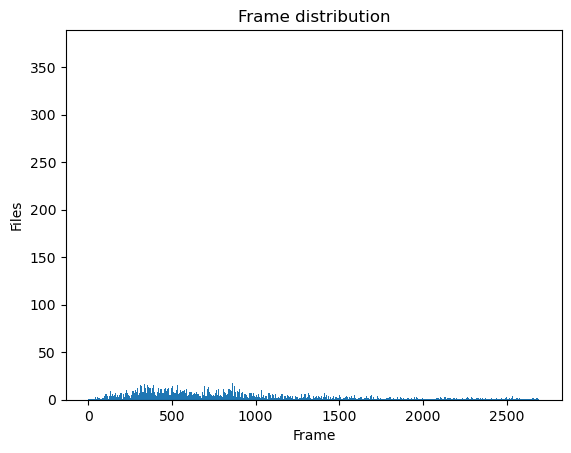

In [10]:
counts, _, _ = plt.hist(sorted_info_data['Frame'], bins=n_frames_actual);
plt.xlabel('Frame'), plt.ylabel('Files'), plt.title('Frame distribution');
plt.ylim(0, max(counts)+1);

##### collecting frame data

In [186]:
directory = '../../MaNGA'
os.makedirs(f'{directory}/frames', exist_ok=True)
n_frames_actual = len(np.unique(sorted_info_data['Frame']))

for frame in np.unique(sorted_info_data['Frame']):
    j=1
    frame_subset = sorted_info_data[sorted_info_data['Frame'] == frame]
    
    all_points = [cp.empty((0, 3), dtype=cp.float32) for _ in range(6)]
    all_colors = [cp.empty((0, 3), dtype=cp.float32) for _ in range(6)]
    
    for i, object in frame_subset.iterrows():
        print(f'Processing group {frame}/{n_frames_actual}: {j}/{len(frame_subset)} objects          ', end='\r')
        
        file_path = object["Filename"]
        _, pixel_info = get_data(f'{directory}/raw/{file_path}', downsample=8)
        points = cp.array(pixel_info[0], dtype=cp.float32) # shape: (depth_layers * 5476, 3)
        colors = cp.array(pixel_info[1], dtype=cp.float32) # colors final shape before tiling for depth layers: (6, 5476, 3)
        
        for life_stage in range(6): # stack the objects together for each life stage
            all_points[life_stage] = cp.vstack([all_points[life_stage], points])
            all_colors[life_stage] = cp.vstack([all_colors[life_stage], colors[life_stage]])
            
        j += 1
    
    # stack the life stages together
    all_points = cp.asnumpy(cp.vstack(all_points))
    all_colors = cp.asnumpy(cp.vstack(all_colors))
    
    print(f'Saving frame {frame}/{n_frames_actual}...                                                                  ', end='\r')
    np.savez_compressed(f'{directory}/frames/frame-{frame}.npz', points=all_points, colors=all_colors)

##### small test

In [5]:
frame = 228 # 10 files
directory = '../../MaNGA'
sorted_info_data = pd.read_csv('sorted_info_data.csv', header=0)
# ==================================================
# file_path = next(f for f in os.listdir(f'{directory}/frames') if f'frame-{frame}' in f)
# test_load = np.load(file)
# points = test_load['points']
# points = np.nan_to_num(points, nan=0) # replace nans with 0s
# colors = test_load['colors']

# print(f'Min color: {np.min(colors)}, Max color: {np.max(colors)}')
# print(f'Points shape: {points.shape}, Colors shape: {colors.shape}')

# pca = KernelPCA(n_components=3, kernel='cosine')
# pca_coords = pca.fit_transform(points)
# tsne = TSNE(n_components=3, perplexity=10, n_iter=300)
# tsne_coords = tsne.fit_transform(pca_coords)

# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(tsne_coords)
# pcd.colors = o3d.utility.Vector3dVector(colors)

# o3d.visualization.draw_geometries([pcd], window_name="Galaxy Mapping", width=1200, height=600, left=80, top=50)

# ==================================================
files = sorted_info_data[sorted_info_data['Frame'] == frame]['Filename']
pcds = []
for file in files:
    _, pixel_info = get_data(f'{directory}/raw/{file}', downsample=8)
    points = pixel_info[0]
    points = np.nan_to_num(points, nan=0)
    colors = pixel_info[1]

    pca = KernelPCA(n_components=3, kernel='cosine')
    pca_coords = pca.fit_transform(points)
    # tsne = TSNE(n_components=3, perplexity=10, n_iter=300)
    # tsne_coords = tsne.fit_transform(pca_coords)
    
    umap_coords = umap.UMAP(
        n_neighbors=10, # range 2 to 100, local-->global relationship
        min_dist=0.1, # determines how clustered the points are
        n_components=3,
        random_state=42,
    ).fit_transform(pca_coords)
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(umap_coords)
    pcd.colors = o3d.utility.Vector3dVector(colors[5])
    pcds.append(pcd)

o3d.visualization.draw_geometries(pcds, window_name="Galaxy Mapping", width=1200, height=600, left=80, top=50)

In [16]:
print(points.shape)

(6400, 3)


In [14]:
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Galaxy Mapping", width=1200, height=600, left=80, top=50)

lock = threading.Lock()
def update_vis(file, vis):
        test_load = np.load(file)
        points = test_load['points']
        points = np.nan_to_num(points, nan=0) # replace nans with 0s
        colors = test_load['colors']

        # print(f'Min color: {np.min(colors)}, Max color: {np.max(colors)}')
        # print(f'Points shape: {points.shape}, Colors shape: {colors.shape}')

        pca = KernelPCA(n_components=3, kernel='cosine')
        pca_coords = pca.fit_transform(points)
        tsne = TSNE(n_components=3, perplexity=10, n_iter=300)
        tsne_coords = tsne.fit_transform(pca_coords)

        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(tsne_coords)
        pcd.colors = o3d.utility.Vector3dVector(colors)
        
        with lock:
            vis.add_geometry(pcd)
            vis.update_renderer()

frames = [1257, 672, 11, 1110, 14, 1551]
def process_frames():
    for frame in frames:
        print(f'Processing frame {frame}... ', end='\r')
        update_vis(f'../../MaNGA/frames/frame-{frame}.npz', vis)
        time.sleep(0.5)

thread = threading.Thread(target=process_frames)
thread.start()
while thread.is_alive():
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.05)

vis.run()
vis.destroy_window()

Exception in thread Thread-18 (process_frames):
Traceback (most recent call last):
  File "c:\Users\ebaca\anaconda3\envs\dxarts\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\ebaca\anaconda3\envs\dxarts\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\ebaca\anaconda3\envs\dxarts\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\ebaca\AppData\Local\Temp\ipykernel_21072\1469346937.py", line 31, in process_frames
  File "C:\Users\ebaca\AppData\Local\Temp\ipykernel_21072\1469346937.py", line 15, in update_vis
  File "c:\Users\ebaca\anaconda3\envs\dxarts\Lib\site-packages\sklearn\utils\_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ebaca\anaconda3\envs\dxarts\Lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 476, in fit_transform


In [ ]:
# sorted_info_data.head()

for frame in np.unique(sorted_info_data['Frame']):
    print(f'Frame {frame}: {len(sorted_info_data[sorted_info_data["Frame"] == frame])} files')

Frame 1: 1 files
Frame 2: 388 files
Frame 3: 1 files
Frame 4: 1 files
Frame 5: 1 files
Frame 6: 1 files
Frame 7: 1 files
Frame 8: 1 files
Frame 9: 1 files
Frame 10: 1 files
Frame 11: 1 files
Frame 12: 1 files
Frame 13: 1 files
Frame 14: 1 files
Frame 15: 1 files
Frame 16: 1 files
Frame 17: 1 files
Frame 18: 1 files
Frame 19: 1 files
Frame 20: 1 files
Frame 21: 1 files
Frame 22: 1 files
Frame 23: 1 files
Frame 24: 1 files
Frame 25: 1 files
Frame 26: 1 files
Frame 27: 1 files
Frame 28: 1 files
Frame 29: 1 files
Frame 30: 1 files
Frame 31: 1 files
Frame 32: 1 files
Frame 33: 1 files
Frame 34: 1 files
Frame 35: 1 files
Frame 36: 2 files
Frame 37: 1 files
Frame 38: 1 files
Frame 39: 2 files
Frame 40: 1 files
Frame 41: 4 files
Frame 42: 1 files
Frame 43: 3 files
Frame 44: 1 files
Frame 45: 1 files
Frame 46: 1 files
Frame 47: 2 files
Frame 48: 1 files
Frame 49: 1 files
Frame 50: 2 files
Frame 51: 1 files
Frame 52: 1 files
Frame 53: 2 files
Frame 54: 1 files
Frame 55: 3 files
Frame 56: 1 files

#### data extraction (iteration 2)

In [ ]:
'''
TO DOs:
- figure out why there were nan values in the data
- fix when starting vectors are zeroes
- condense the frames (figure out minimum file count to increase to) to increase point counts
        - memory issues
        - maybe dynamic downsample? 
        - cap pixel count per frame to maintain point density?
- maybe separate life cycle stages into different frames, might be able to transition between objects better by blending last/first?

Fixes:
- add noise to data for jiggle/natural movement effect, might help with zero starting vectors?
- add cap to pixel count, keep point density consistent with 50,000 pixels per frame
        - add dynamic downsample to maintain point density
        - bins with more galaxies should be downsampled more
        - group bins with only a few galaxies together to maintain point density
        - use one .npz file per time step (life stages)
- add color of each stage to position data in data analysis for more movement between stages
'''

##### sorting

In [80]:
data_info = pd.read_csv('sorted_info_data.csv', header=0)
df = data_info.sort_values(by="Age").reset_index(drop=True)

current_frame = 1
current_pixel_count = 0

# reallocating frames
for idx, row in df.iterrows():
    
    if current_pixel_count < 50000:
        df.loc[idx, "Frame"] = current_frame
        current_pixel_count += row['Pixels']
    
    if current_pixel_count >= 50000:
        current_frame += 1
        current_pixel_count = 0

print('Finished reassigning frames. Adjusting pixels...')

# downsizing pixels
for frame in np.unique(df['Frame']):
    print(f'Frame {frame}...                              ', end='\r')
    
    mask = df['Frame'] == frame
    frame_subset = df[mask]
    sum_pixels = frame_subset['Pixels'].sum()
    
    percents = frame_subset['Pixels'] / sum_pixels
    df.loc[mask, "Adjusted_Pixels"] = (percents * 50000).astype(int)
    df.loc[mask, "Adjusted_Length"] = df[mask]['Adjusted_Pixels'].apply(lambda x: int(np.sqrt(x)))

df.to_csv('adjusted_info_data.csv', index=False)
df.head()

Finished reassigning frames. Adjusting pixels...


,Plateifu,Age,Distance,Redshift,Velocity,X,Y,Z,Frame,Filename,Pixels,Shape,Adjusted_Pixels,Adjusted_Length
0,8309-1901,-0.009394,-2.877269,-0.00065,-194.773061,-1.472268,-0.853901,2.319905,1,manga-8309-1901-MAPS-HYB10-MILESHC-MASTARSSP.f...,1156,"(35, 34, 34)",1113.0,33.0
1,10145-9101,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1,manga-10145-9101-MAPS-HYB10-MILESHC-MASTARSSP....,3844,"(35, 62, 62)",3702.0,60.0
2,12048-12702,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1,manga-12048-12702-MAPS-HYB10-MILESHC-MASTARSSP...,5476,"(35, 74, 74)",5274.0,72.0
3,9675-12705,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1,manga-9675-12705-MAPS-HYB10-MILESHC-MASTARSSP....,5476,"(35, 74, 74)",5274.0,72.0
4,9675-12704,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1,manga-9675-12704-MAPS-HYB10-MILESHC-MASTARSSP....,5184,"(35, 72, 72)",4993.0,70.0


##### collecting frame data

In [9]:
directory = '../../MaNGA'
save_folder = f'{directory}/frames2'
os.makedirs(save_folder, exist_ok=True)
adjusted_info_data = pd.read_csv('adjusted_info_data.csv')
n_frames_actual = len(np.unique(adjusted_info_data['Frame']))

resume = 679

for frame in np.unique(adjusted_info_data['Frame'] if resume == 0 else range(resume, 680)): # range is exclusive
    j=1
    frame_subset = adjusted_info_data[adjusted_info_data['Frame'] == frame]
    
    all_points = cp.empty((0, 3), dtype=cp.float32)
    all_colors = [cp.empty((0, 3), dtype=cp.float32) for _ in range(6)]
    
    for i, object in frame_subset.iterrows():
        print(f'Processing group {frame}/{n_frames_actual}: {j}/{len(frame_subset)} objects          ', end='\r')
        
        file_path = object["Filename"]
        adjusted_length = int(object["Adjusted_Length"])
        pixel_info = get_data(f'{directory}/raw/{file_path}', downsample=adjusted_length, pixels_only=True)
        points = cp.array(pixel_info[0], dtype=cp.float32) # shape: (depth_layers * 5476, 3)
        colors = cp.array(pixel_info[1], dtype=cp.float32) # colors final shape before tiling for depth layers: (6, 5476, 3)
        
        all_points = cp.vstack([all_points, points])
        for life_stage in range(6):
            all_colors[life_stage] = cp.vstack([all_colors[life_stage], colors[life_stage]])
            
        j += 1

    # add padding to points/colors and save
    if len(all_points) < 50000:
        padding = 50000 - len(all_points)
        all_points = np.pad(all_points, ((0, padding), (0, 0)), mode='constant', constant_values=0)
    
    for life_stage in range(6):
        identity = f'{frame}-{life_stage+1}'
        
        life_points = jitter_positions(cp.asnumpy(all_points), intensity=0.1)
        life_colors = cp.asnumpy(all_colors[life_stage])
        if len(life_colors) < 50000:
            padding = 50000 - len(life_colors)
            life_colors = np.pad(life_colors, ((0, padding), (0, 0)), mode='constant', constant_values=0)
        
        
        print(f'Saving frame {identity}/{n_frames_actual}...                                                                  ', end='\r')
        np.savez_compressed(f'{save_folder}/frame_{identity}.npz', points=life_points, colors=life_colors)
print('Done.                                                                                                                   ', end='\r')

see `script.py` to see code for editing out extra depth layers

##### testing

In [ ]:
in_folder = '../../MaNGA/frames2'
out_folder = '../../MaNGA'
os.makedirs(out_folder, exist_ok=True)
selected_frame = '93-2' # [1-679] for frame, [1-6] for life stage

file = np.load(f'{in_folder}/frame_{selected_frame}.npz')
points = file['points']
colors = file['colors']
print(f'Points shape: {points.shape}, Colors shape: {colors.shape}')

# pca_coords = KernelPCA(
#     n_components=3, 
#     kernel='cosine',
#     eigen_solver='arpack',
#     n_jobs=-1
#     ).fit_transform(np.hstack([points, colors]))
tsne_coords = TSNE( # ~2:15 with KernelPCA + tSNE | ~2:30 with PCA + mTSNE | ~1:30 by itself
    n_components=3, 
    perplexity=30, 
    n_iter=300,
    n_jobs=-1
    ).fit_transform(np.hstack([points, colors]))
# pca_coords = PCA(n_components=3).fit_transform(points)
# pca_coords = KernelPCA(n_components=3, kernel='cosine').fit_transform(np.hstack([points, colors]))
# umap_coords = umap.UMAP( # ~32s with PCA + UMAP | ~1:11 with KernelPCA + UMAP
#         init = 'pca',
#         n_neighbors=10, # range 2 to 100, local-->global relationship
#         min_dist=0.1, # determines how clustered the points are
#         n_components=3,
#         random_state=42,
#         low_memory=True
#     ).fit_transform(pca_coords)
print('Analysis complete.')

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(tsne_coords)
pcd.colors = o3d.utility.Vector3dVector(colors)
print('Point cloud created.')

o3d.visualization.draw_geometries([pcd], window_name="Galaxy Mapping", width=1200, height=600, left=80, top=50)
# o3d.io.write_point_cloud(f'{out_folder}/{selected_frame}.ply', pcd)

Points shape: (50000, 3), Colors shape: (50000, 3)
Analysis complete.
Point cloud created.


In [5]:
# load & visualize point cloud .ply files
directory = '../../MaNGA/pointclouds'
file = '1'

pcd = o3d.io.read_point_cloud(f'{directory}/{file}.ply')
o3d.visualization.draw_geometries([pcd], window_name="Galaxy Mapping", width=1200, height=600, left=80, top=50)

# get range of pcd colors
colors = np.asarray(pcd.colors)
print(f'Min color: {np.min(colors)}, Max color: {np.max(colors)}')

Min color: 0.0, Max color: 1.0


#### data extraction (iteration 3)

##### adjusting

In [4]:
data_info = pd.read_csv('sorted_info_data.csv', header=0)
df = data_info.sort_values(by="Age").reset_index(drop=True)

# downsizing pixels
for frame in np.unique(df['Frame']):
    print(f'Frame {frame}...                              ', end='\r')
    
    mask = df['Frame'] == frame
    frame_subset = df[mask]
    sum_pixels = frame_subset['Pixels'].sum()
    
    percents = frame_subset['Pixels'] / sum_pixels
    df.loc[mask, "Adjusted_Pixels"] = (percents * 50000).astype(int)
    df.loc[mask, "Adjusted_Length"] = df[mask]['Adjusted_Pixels'].apply(lambda x: int(np.sqrt(x)))

df.to_csv('adjusted_info_data2.csv', index=False)
df.head()

,Plateifu,Age,Distance,Redshift,Velocity,X,Y,Z,Frame,Filename,Pixels,Shape,Adjusted_Pixels,Adjusted_Length
0,8309-1901,-0.009394,-2.877269,-0.00065,-194.773061,-1.472268,-0.853901,2.319905,1,manga-8309-1901-MAPS-HYB10-MILESHC-MASTARSSP.f...,1156,"(35, 34, 34)",50000.0,223.0
1,10482-12705,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2,manga-10482-12705-MAPS-HYB10-MILESHC-MASTARSSP...,5184,"(35, 72, 72)",139.0,11.0
2,10482-12704,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2,manga-10482-12704-MAPS-HYB10-MILESHC-MASTARSSP...,5184,"(35, 72, 72)",139.0,11.0
3,10482-12703,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2,manga-10482-12703-MAPS-HYB10-MILESHC-MASTARSSP...,5184,"(35, 72, 72)",139.0,11.0
4,10482-12702,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2,manga-10482-12702-MAPS-HYB10-MILESHC-MASTARSSP...,5184,"(35, 72, 72)",139.0,11.0


##### collecting

In [ ]:
directory = '../../MaNGA'
save_folder = f'{directory}/pointclouds2'
os.makedirs(save_folder, exist_ok=True)
adjusted_info_data = pd.read_csv('adjusted_info_data2.csv')
n_frames_actual = len(np.unique(adjusted_info_data['Frame']))

resume = 0
k=1
for frame in np.unique(adjusted_info_data['Frame'] if resume == 0 else range(resume, n_frames_actual+1)): # range is exclusive
    j=1
    frame_subset = adjusted_info_data[adjusted_info_data['Frame'] == frame]
    
    all_points = cp.empty((0, 3), dtype=cp.float32)
    all_colors = [cp.empty((0, 3), dtype=cp.float32) for _ in range(6)]
    
    for i, object in frame_subset.iterrows():
        print(f'Processing group {frame}/{n_frames_actual}: {j}/{len(frame_subset)} objects          ', end='\r')
        
        file_path = object["Filename"]
        adjusted_length = int(object["Adjusted_Length"])
        pixel_info = get_data(f'{directory}/raw/{file_path}', downsample=adjusted_length, pixels_only=True)
        points = cp.array(pixel_info[0], dtype=cp.float32) # shape: (depth_layers * 5476, 3)
        colors = cp.array(pixel_info[1], dtype=cp.float32) # colors final shape before tiling for depth layers: (6, 5476, 3)
        
        all_points = cp.vstack([all_points, points])
        for life_stage in range(6):
            all_colors[life_stage] = cp.vstack([all_colors[life_stage], colors[life_stage]])
            
        j += 1

    # add padding to points/colors and save
    if len(all_points) < 50000:
        padding = 50000 - len(all_points)
        all_points = np.pad(all_points, ((0, padding), (0, 0)), mode='constant', constant_values=0)
    
    for life_stage in range(6):
        identity = f'{frame}-{life_stage+1}'
        
        life_points = jitter_positions(cp.asnumpy(all_points), intensity=0.4)
        life_colors = cp.asnumpy(all_colors[life_stage])
        if len(life_colors) < 50000:
            padding = 50000 - len(life_colors)
            life_colors = np.pad(life_colors, ((0, padding), (0, 0)), mode='constant', constant_values=0)
        
        # data reduction/analysis
        pca = PCA(n_components=3)
        pca_coords = pca.fit_transform(np.hstack([life_points, life_colors]))
        reducer = TSNE(
            n_components=3,
            perplexity=30, 
            n_iter=300, 
            n_jobs=-1, 
            random_state=None
            )
        reducer_coords = reducer.fit_transform(pca_coords)
        
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(reducer_coords)
        
        color_array = colors[:len(reducer_coords)]
        if np.max(color_array) > 1.0:
            color_array = color_array.astype(float) / 255.0
        color_array = np.clip(color_array, 0.0, 1.0)
        pcd.colors = o3d.utility.Vector3dVector(color_array)
        
        print(f'Saving frame {identity}/{n_frames_actual}...                                                                  ', end='\r')
        out_path = f"{save_folder}/{k}.ply"
        o3d.io.write_point_cloud(out_path, pcd, write_ascii=True, compressed=False)
        k += 1

print('Done.                                                                                                                   ', end='\r')

##### testing

In [6]:
# load & visualize point cloud .ply files
directory = '../../MaNGA/pointclouds2'
file = '106'

pcd = o3d.io.read_point_cloud(f'{directory}/{file}.ply')
o3d.visualization.draw_geometries([pcd], window_name="Galaxy Mapping", width=1200, height=600, left=80, top=50)

# get range of pcd colors
colors = np.asarray(pcd.colors)
print(f'Min color: {np.min(colors)}, Max color: {np.max(colors)}')

Min color: 0.0, Max color: 1.0


#### audio component

min youngest: 0.006263527441355832 | max youngest: 3.523917818898845
min oldest: 502.566669327053 | max oldest: 4296.142019581478
min middle: 79.83419676162639 | max middle: 509.6388769110577


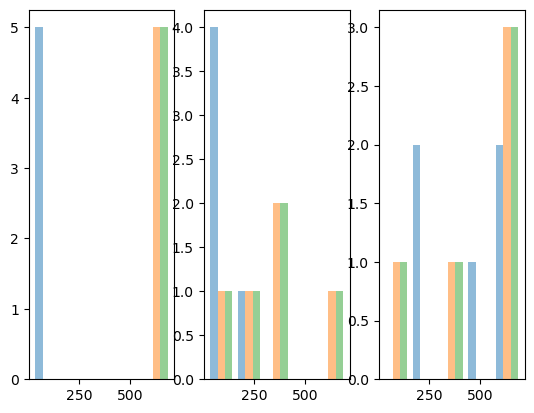

Average frequency for youngest: 473
Average frequency for oldest: 242
Average frequency for middle: 438
Average frequency overall: 384


In [3]:
adjusted_info_data = pd.read_csv('adjusted_info_data2.csv')
df = adjusted_info_data.sort_values(by="Age").reset_index(drop=True)

youngest_object = df.iloc[:5]
oldest_object = df.iloc[-5:]
middle_object = df.iloc[(df['Age'] - df['Age'].median()).abs().argsort()[:5]] # middle child!!!

# grab positions
youngest_xyz = youngest_object[['X', 'Y', 'Z']].values
oldest_xyz = oldest_object[['X', 'Y', 'Z']].values
middle_xyz = middle_object[['X', 'Y', 'Z']].values

# fourier transform to frequency space
youngest_fft = np.asarray(np.fft.fftn(youngest_xyz))
oldest_fft = np.asarray(np.fft.fftn(oldest_xyz))
middle_fft = np.asarray(np.fft.fftn(middle_xyz))

print(f'min youngest: {np.min(abs(youngest_fft))} | max youngest: {np.max(abs(youngest_fft))}')
print(f'min oldest: {np.min(abs(oldest_fft))} | max oldest: {np.max(abs(oldest_fft))}')
print(f'min middle: {np.min(abs(middle_fft))} | max middle: {np.max(abs(middle_fft))}')

# normalize between 20 and 700
def normalize(values, actual_bounds, desired_bounds):
    return np.asarray([desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0]) / (actual_bounds[1] - actual_bounds[0]) for x in values])
youngest_fft = normalize(abs(youngest_fft), (np.min(abs(youngest_fft)), np.max(abs(youngest_fft))), (20, 700))
oldest_fft = normalize(abs(oldest_fft), (np.min(abs(oldest_fft)), np.max(abs(oldest_fft))), (20, 700))
middle_fft = normalize(abs(middle_fft), (np.min(abs(middle_fft)), np.max(abs(middle_fft))), (20, 700))

plt.subplot(1,3,1)
plt.hist(youngest_fft, bins=len(youngest_fft), alpha=0.5, label='youngest')
plt.subplot(1,3,2)
plt.hist(oldest_fft, bins=len(oldest_fft), alpha=0.5, label='oldest')
plt.subplot(1,3,3)
plt.hist(middle_fft, bins=len(middle_fft), alpha=0.5, label='middle')
plt.show()

print(f'Average frequency for youngest: {np.average(youngest_fft):.0f}')
print(f'Average frequency for oldest: {np.average(oldest_fft):.0f}')
print(f'Average frequency for middle: {np.average(middle_fft):.0f}')
print(f'Average frequency overall: {np.average([youngest_fft, oldest_fft, middle_fft]):.0f}')